<a href="https://colab.research.google.com/github/Otobi1/Predictors-of-Breast-Cancer-Recurrence/blob/master/Predictors_of_Cancer_Recurrence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the necessary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import collections
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
 
import warnings
warnings.filterwarnings('ignore')

print ('Libraries successfully imported!')

Libraries successfully imported!


In [2]:
# Downloading the data directly from the Repo - http://archive.ics.uci.edu/ml/datasets/Breast+Cancer

!wget http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data

--2021-04-27 17:14:25--  http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18654 (18K) [application/x-httpd-php]
Saving to: ‘breast-cancer.data’

breast-cancer.data  100%[===================>]  18.22K  --.-KB/s    in 0.03s   

2021-04-27 17:14:25 (667 KB/s) - ‘breast-cancer.data’ saved [18654/18654]



In [3]:
# Naming the feature columns, originally unnamed
# The meaning of each feature is detailed here on pg 2 https://www.causeweb.org/usproc/sites/default/files/usclap/2018-1/Predictors_for_Breast_Cancer_Recurrence.pdf

df = pd.read_csv('breast-cancer.data', sep=',', names=['RecClass', 'Age', 'Menopause',
                                                       'TumorSize', 'InvNodes', 'NodeCaps',
                                                       'DegMalig', 'Breast', 'Quadrant', 'Radiation']) 

# Shuffle data 

df = df.sample(frac = 1).reset_index(drop = True) 

# Make a copy of the data

data = df.copy()

In [4]:
# Exploring the first few observations 

data.head()

,RecClass,Age,Menopause,TumorSize,InvNodes,NodeCaps,DegMalig,Breast,Quadrant,Radiation
0,no-recurrence-events,30-39,premeno,5-9,0-2,no,2,left,right_low,no
1,no-recurrence-events,40-49,premeno,30-34,0-2,no,2,right,right_low,no
2,no-recurrence-events,60-69,ge40,20-24,0-2,no,1,left,left_low,no
3,no-recurrence-events,40-49,ge40,25-29,0-2,no,2,left,left_low,no
4,no-recurrence-events,40-49,premeno,30-34,0-2,no,1,left,right_up,no


In [5]:
# Checking the number of observations and features

data.shape

(286, 10)

In [6]:
# Checking the data type, existence of null cases within the observations

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   RecClass   286 non-null    object
 1   Age        286 non-null    object
 2   Menopause  286 non-null    object
 3   TumorSize  286 non-null    object
 4   InvNodes   286 non-null    object
 5   NodeCaps   286 non-null    object
 6   DegMalig   286 non-null    int64 
 7   Breast     286 non-null    object
 8   Quadrant   286 non-null    object
 9   Radiation  286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [7]:
# Listing out the feature labels 

data.keys()

Index(['RecClass', 'Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps',
       'DegMalig', 'Breast', 'Quadrant', 'Radiation'],
      dtype='object')

In [8]:
# Exploring the unique classes within each feature
# Un-comment each one to check the classes

data['Age'].unique()
# data['Breast'].unique()
# data['DegMalig'].unique()
# data['InvNodes'].unique()
# data['Menopause'].unique()
# data['NodeCaps'].unique()
# data['Quadrant'].unique()
# data['Radiation'].unique()
# data['TumorSize'].unique()
# data['RecClass'].unique()

array(['30-39', '40-49', '60-69', '50-59', '70-79', '20-29'], dtype=object)

In [9]:
# Creation of dummy variables for the various features and prevention of the dummy variable trap (multicollinearity)

# Converting the Age group variable into dummy variables and dropping the first column of the AgeGroup category

# Original unique Age group categories '60-69', '40-49', '30-39', '50-59', '70-79', '20-29' (20 - 29 AgeGroup is dropped to prevent Multicollinearity)

Age = pd.get_dummies(data['Age'], drop_first=True)

data = data.drop('Age', axis=1)

Age = Age.add_prefix('AgeGroup ')

data = pd.concat([data, Age], axis=1)

In [10]:
# Converting the Menopause variable into dummy variables and dropping the first column of the Menopause category

# Original unique Menopause categories 'ge40', 'premeno', 'lt40' (ge40 gets dropped)

Menopause = pd.get_dummies(data['Menopause'], drop_first=True)

data = data.drop('Menopause', axis=1)

Menopause = Menopause.add_prefix('Menopause ')

data = pd.concat([data, Menopause], axis=1)

In [11]:
# Converting the TumorSize variables into dummies and droping the first column 

# Original unique TumorSize categories '30-34', '15-19', '25-29', '20-24', '0-4', '35-39', '10-14','40-44', '50-54', '45-49', '5-9' (0-4 dropped)

TumorSize = pd.get_dummies(data['TumorSize'], drop_first=True)

data = data.drop('TumorSize', axis=1)

TumorSize = TumorSize.add_prefix('TumorSize ')

data = pd.concat([data, TumorSize], axis=1)

In [12]:
# Converting the InvNodes variables into dummies and droping the first column 

# Original unique InvNodes categories '0-2', '12-14', '3-5', '15-17', '6-8', '9-11', '24-26' (0-2 dropped)

InvNodes = pd.get_dummies(data['InvNodes'], drop_first=True)

data = data.drop('InvNodes', axis=1)

InvNodes = InvNodes.add_prefix('InvNodes ')

data = pd.concat([data, InvNodes], axis=1)

In [13]:
# Converting the NodeCaps variables into dummies and droping the first column 

# Original unique NodeCaps categories 'no', 'yes', '? (freaking ? dropped, nice)

NodeCaps = pd.get_dummies(data['NodeCaps'], drop_first=True)

data = data.drop('NodeCaps', axis=1)

NodeCaps = NodeCaps.add_prefix('NodeCaps ')

data = pd.concat([data, NodeCaps], axis=1)

In [14]:
# Converting the Breast variables into dummies and droping the first column 

# Original unique Breast categories 'left', 'right', (left dropped)

Breast = pd.get_dummies(data['Breast'], drop_first=True)

data = data.drop('Breast', axis=1)

Breast = Breast.add_prefix('Breast ')

data = pd.concat([data, Breast], axis=1)

In [15]:
# Converting the Quadrant variables into dummies and droping the first column 

# Original unique Quadrant categories 'left_low', 'right_low', 'central', 'left_up', 'right_up', '?' (freaking ? dropped again, nice)

Quadrant = pd.get_dummies(data['Quadrant'], drop_first=True)

data = data.drop('Quadrant', axis=1)

Quadrant = Quadrant.add_prefix('Quadrant ')

data = pd.concat([data, Quadrant], axis=1)

In [16]:
# Converting the Radiation variables into dummies and droping the first column 

# Original unique Radiation categories 'no', 'yes' (no dropped)

Radiation = pd.get_dummies(data['Radiation'], drop_first=True)

data = data.drop('Radiation', axis=1)

Radiation = Radiation.add_prefix('Radiation ')

data = pd.concat([data, Radiation], axis=1)

In [17]:
# Checking a sample of 20 observations from the dataset

data.sample(20)

,RecClass,DegMalig,AgeGroup 30-39,AgeGroup 40-49,AgeGroup 50-59,AgeGroup 60-69,AgeGroup 70-79,Menopause lt40,Menopause premeno,TumorSize 10-14,TumorSize 15-19,TumorSize 20-24,TumorSize 25-29,TumorSize 30-34,TumorSize 35-39,TumorSize 40-44,TumorSize 45-49,TumorSize 5-9,TumorSize 50-54,InvNodes 12-14,InvNodes 15-17,InvNodes 24-26,InvNodes 3-5,InvNodes 6-8,InvNodes 9-11,NodeCaps no,NodeCaps yes,Breast right,Quadrant central,Quadrant left_low,Quadrant left_up,Quadrant right_low,Quadrant right_up,Radiation yes
66,no-recurrence-events,2,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
36,recurrence-events,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
177,no-recurrence-events,3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
234,no-recurrence-events,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
119,recurrence-events,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0
266,no-recurrence-events,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
237,no-recurrence-events,2,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
185,no-recurrence-events,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
252,no-recurrence-events,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
31,recurrence-events,3,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   RecClass            286 non-null    object
 1   DegMalig            286 non-null    int64 
 2   AgeGroup 30-39      286 non-null    uint8 
 3   AgeGroup 40-49      286 non-null    uint8 
 4   AgeGroup 50-59      286 non-null    uint8 
 5   AgeGroup 60-69      286 non-null    uint8 
 6   AgeGroup 70-79      286 non-null    uint8 
 7   Menopause lt40      286 non-null    uint8 
 8   Menopause premeno   286 non-null    uint8 
 9   TumorSize 10-14     286 non-null    uint8 
 10  TumorSize 15-19     286 non-null    uint8 
 11  TumorSize 20-24     286 non-null    uint8 
 12  TumorSize 25-29     286 non-null    uint8 
 13  TumorSize 30-34     286 non-null    uint8 
 14  TumorSize 35-39     286 non-null    uint8 
 15  TumorSize 40-44     286 non-null    uint8 
 16  TumorSize 45-49     286 no

In [19]:
# Checking th final shape of the dataset

data.shape

(286, 34)

In [20]:
# Mapping the input features into the X dataframe and the labels into y

X = data._get_numeric_data()
y = data['RecClass']

# Creating the train and test data splits 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 1919)

In [21]:
# Checking the size and dimensions of the data splits 

print (f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print (f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (214, 33), y_train: (214,)
X_test: (72, 33), y_test: (72,)


In [22]:
# Exploring the overall class distribution
# To see if the labels are fairly evenly distributed between the data splits

class_count = dict(collections.Counter(y))
train_class_count = dict(collections.Counter(y_train))
test_class_count = dict(collections.Counter(y_test))

print (f'classes: {class_count}')
print (f"no-rec:rec = {class_count['no-recurrence-events']/class_count['recurrence-events']:.2f}")
print (f'train classes: {train_class_count}')
print (f"train no-rec:rec = {train_class_count['no-recurrence-events']/train_class_count['recurrence-events']:.2f}")
print (f'test classes: {test_class_count}')
print (f"test no-rec:rec = {test_class_count['no-recurrence-events']/test_class_count['recurrence-events']:.2f}")

classes: {'no-recurrence-events': 201, 'recurrence-events': 85}
no-rec:rec = 2.36
train classes: {'no-recurrence-events': 150, 'recurrence-events': 64}
train no-rec:rec = 2.34
test classes: {'no-recurrence-events': 51, 'recurrence-events': 21}
test no-rec:rec = 2.43


In [23]:
# Standardising the data (mean = 0, std = 1) using the training data

X_scaler = StandardScaler().fit(X_train)

# Not necessary to standardise the data using the StandardScaler class of Sklearn as the orders of magnitude are in single digits

In [24]:
# Applying the scaler on training and test data (not necessary to standardise outputs for classification)

X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [25]:
# Check (mean should approx 0 and std should be approx 1)

print (f'X_train[0]: mean: {np.mean(X_train[:, 0], axis = 0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}')
print (f'X_test[1]: mean: {np.mean(X_test[:, 1], axis = 0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}')

X_train[0]: mean: -0.0, std: 1.0
X_test[1]: mean: -0.1, std: 0.9


In [26]:
# Base Model 

y.value_counts(normalize=True)

# A base model that predicts no recurrence events would be correct 70% of the time

no-recurrence-events    0.702797
recurrence-events       0.297203
Name: RecClass, dtype: float64

In [27]:
pipe = Pipeline(steps=[('lr', LogisticRegression())]) # Running a pipeline of logistic regression 

params = {'lr__penalty': ['l1'], 
          'lr__C': [1], 
          'lr__solver': ['liblinear']} # setting parameters

gs_lr = GridSearchCV(pipe, param_grid=params, cv=5,scoring='accuracy', n_jobs=-2)

gs_lr.fit(X_train, y_train)
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [28]:
# Predicting the first 5 observations 

log_reg_y_pred = gs_lr.best_estimator_.predict(X_test[:5])
log_reg_y_pred

array(['no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events', 'no-recurrence-events',
       'no-recurrence-events'], dtype=object)

In [29]:
# Checking the actual labels for the first 5 observations

print (f'Actual labels: {y_test[:5]}')

Actual labels: 176    no-recurrence-events
41     no-recurrence-events
221    no-recurrence-events
137       recurrence-events
143       recurrence-events
Name: RecClass, dtype: object


In [30]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_lr.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_lr.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_lr.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.7570093457943925
cross validation score: 0.7238354506957048
test score: 0.7361111111111112


In [31]:
pipe = Pipeline(steps=[('sc', StandardScaler()), ('knn', KNeighborsClassifier())])

params = {'knn__n_neighbors': [21], 'knn__p': [1]}

gs_knn = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

gs_knn.fit(X_train, y_train)
gs_knn.best_estimator_

Pipeline(memory=None,
         steps=[('sc',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=21, p=1,
                                      weights='uniform'))],
         verbose=False)

In [32]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_knn.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_knn.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_knn.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.7149532710280374
cross validation score: 0.6852994555353902
test score: 0.7361111111111112


In [33]:
# Decision Tree Classifer

pipe = Pipeline(steps=[('tree', DecisionTreeClassifier())])

params = {'tree__max_depth': [6, 8]}

gs_tree = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

gs_tree.fit(X_train, y_train)
gs_tree.best_estimator_

Pipeline(memory=None,
         steps=[('tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=6,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [34]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_tree.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_tree.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_tree.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.883177570093458
cross validation score: 0.7202056866303691
test score: 0.7916666666666666


In [35]:
# Bagging Classifier Model 

pipe = Pipeline(steps = [('bag', BaggingClassifier())])

params = {'bag__n_estimators': [200]}

gs_bag = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

gs_bag.fit(X_train, y_train)
gs_bag.best_estimator_

Pipeline(memory=None,
         steps=[('bag',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=1.0,
                                   max_samples=1.0, n_estimators=200,
                                   n_jobs=None, oob_score=False,
                                   random_state=None, verbose=0,
                                   warm_start=False))],
         verbose=False)

In [36]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_bag.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_bag.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_bag.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.985981308411215
cross validation score: 0.7235329703569267
test score: 0.7777777777777778


In [37]:
# Random Forest Model 

pipe = Pipeline(steps=[('forest', RandomForestClassifier())])

params = {'forest__n_estimators': [150], 'forest__max_depth':[15]}

gs_forest = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

gs_forest.fit(X_train, y_train)

gs_forest.best_estimator_

Pipeline(memory=None,
         steps=[('forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [38]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_forest.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_forest.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_forest.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.985981308411215
cross validation score: 0.7445251058681185
test score: 0.7638888888888888


In [39]:
# Extra Trees Model 

pipe = Pipeline(steps=[('extra', ExtraTreesClassifier())])

params = {'extra__n_estimators': [600], 'extra__max_depth': [None]}

gs_extra = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

gs_extra.fit(X_train, y_train)
gs_extra.best_estimator_

Pipeline(memory=None,
         steps=[('extra',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=600, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

In [40]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_extra.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_extra.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_extra.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.985981308411215
cross validation score: 0.7235934664246824
test score: 0.7916666666666666


In [41]:
# AdaBoost Model 

pipe = Pipeline(steps=[('ada', AdaBoostClassifier())])

params = {'ada__n_estimators': [10]}

gs_ada = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

gs_ada.fit(X_train, y_train)

gs_ada.best_estimator_

Pipeline(memory=None,
         steps=[('ada',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=10,
                                    random_state=None))],
         verbose=False)

In [42]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_ada.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_ada.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_ada.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.7616822429906542
cross validation score: 0.7202661826981246
test score: 0.7777777777777778


In [43]:
# Gradient Boosting Classifier Model 

pipe = Pipeline(steps=[('grad', GradientBoostingClassifier())])

params = {'grad__n_estimators': [300], 'grad__max_depth': [3]}

gs_grad = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

gs_grad.fit(X_train, y_train)
gs_grad.best_estimator_

Pipeline(memory=None,
         steps=[('grad',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=300,
                                            n_iter_no_change=None,
                                            presort='deprecated',
                                            random_sta

In [44]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_grad.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_grad.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_grad.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.9813084112149533
cross validation score: 0.6992740471869329
test score: 0.7638888888888888


In [45]:
# SVC Model 

# - Setting up the model 

pipe = Pipeline(steps = [("svc", SVC())])

# - Setting the model parameters 

params = {"svc__C": [3]}

gs_svc = GridSearchCV(pipe, param_grid = params, cv = 5, scoring = "accuracy")

gs_svc.fit(X_train, y_train)

gs_svc.best_estimator_

Pipeline(memory=None,
         steps=[('svc',
                 SVC(C=3, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [46]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_svc.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_svc.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_svc.score(X_test, y_test)}")

# Inference: this model performs worse than the base model

training score: 0.9299065420560748
cross validation score: 0.7691470054446461
test score: 0.7361111111111112


In [47]:
# Voting Classifier Model 

knn_pipe = Pipeline([('ss', StandardScaler()), ('knn', KNeighborsClassifier())])

vote = VotingClassifier([('rand', RandomForestClassifier()), 
                         ('grad', GradientBoostingClassifier()), 
                         ('lr', LogisticRegression()), 
                         ('tree', DecisionTreeClassifier()), 
                         ('bag', BaggingClassifier()), 
                         ('ada', AdaBoostClassifier()), 
                         ('extra', ExtraTreesClassifier()), 
                         ('knn_pipe', knn_pipe)], voting = 'soft')

vote_params = {'rand__n_estimators': [150], 
               'rand__max_depth': [15], 
               'grad__n_estimators': [300], 
               'tree__max_depth': [8], 
               'bag__n_estimators': [200], 
               'ada__n_estimators': [10], 
               'extra__n_estimators': [600], 
               'knn_pipe__knn__n_neighbors': [21], 
               'lr__penalty': ['l1'], 
               'lr__C': [1], 
               'lr__solver': ['liblinear']}

gs_vc = GridSearchCV(vote, param_grid=vote_params, cv=5, scoring='accuracy')

gs_vc.fit(X_train, y_train)

gs_vc.best_estimator_

VotingClassifier(estimators=[('rand',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=15,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
        

In [48]:
# Scoring the model (trainin, cross validation and test score)

print (f'training score: {gs_vc.score(X_train, y_train)}')
print (f"cross validation score: {cross_val_score(gs_vc.best_estimator_, X, y, cv=5).mean()}")
print (f"test score: {gs_vc.score(X_test, y_test)}")

# Inference, voting classifier performs slightly slightly worse than decision tree, random forest and bagging classifer models although those ones like the voting classifer
# ... clearly overfit the data. 
# Also as voting classifiers are ensemble, they are difficult to interprete

training score: 0.9579439252336449
cross validation score: 0.7411978221415608
test score: 0.8055555555555556


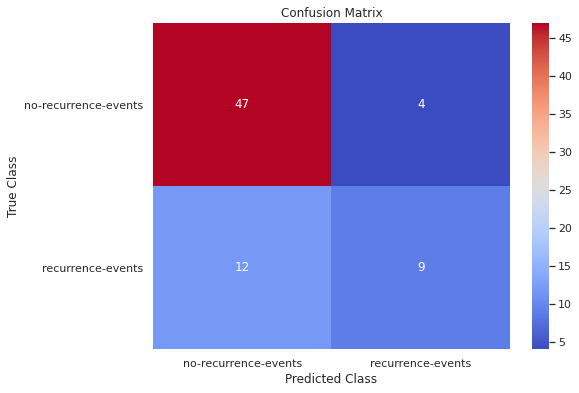

In [49]:
# Model evaluation 

# Getting the prediction from all the models

lr_preds = gs_lr.best_estimator_.predict(X_test)
knn_preds = gs_knn.best_estimator_.predict(X_test)
tree_preds = gs_tree.best_estimator_.predict(X_test)
bag_preds = gs_bag.best_estimator_.predict(X_test) # really good on confusion matrix
forest_preds = gs_forest.best_estimator_.predict(X_test)
extra_preds = gs_extra.best_estimator_.predict(X_test)
ada_preds = gs_ada.best_estimator_.predict(X_test)
svc_preds = gs_svc.best_estimator_.predict(X_test) # as good as the bag preds on confusion matrix
vc_preds = gs_vc.best_estimator_.predict(X_test) 

def pretty_confusion_matrix(y_true, y_pred):
  """ Creating a confusion in a nice chart."""

  # Handling the data
  cm = confusion_matrix(y_true, y_pred)
  labels = y_true.unique()
  labels.sort()

  # Plotting 
  sns.set(font_scale=1)
  plt.figure(figsize=(8, 6))

  chart = sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', xticklabels=labels, yticklabels=labels)
  chart.set_yticklabels(chart.get_yticklabels(), rotation = 0)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')

pretty_confusion_matrix(y_test, bag_preds) # Substitute the predictions in based on the model of choice

In [50]:
# Computing the outcomes of the confusion matrix depending on the selected model

print(f'No-recurrence-events: {48/(48+3)}')
print(f'Recurrence-events: {5/(16+5)}')

No-recurrence-events: 0.9411764705882353
Recurrence-events: 0.23809523809523808


In [51]:
# Evaluating the Bagging Classifer, turns out to be one of the reasonable models based on the confusion matrix

print (f'confusion matrix:\n {confusion_matrix(y_test, bag_preds)}')
print (f'classification report:\n {classification_report(y_test, bag_preds)}')
print (f'accuracy score:\n {accuracy_score(y_test, bag_preds)}')

confusion matrix:
 [[47  4]
 [12  9]]
classification report:
                       precision    recall  f1-score   support

no-recurrence-events       0.80      0.92      0.85        51
   recurrence-events       0.69      0.43      0.53        21

            accuracy                           0.78        72
           macro avg       0.74      0.68      0.69        72
        weighted avg       0.77      0.78      0.76        72

accuracy score:
 0.7777777777777778


In [52]:
# Evaluating the Support Vector Classifer, turns out to be one of the good models based on the confusion matrix alongside the Bagging Classifier

print (f'confusion matrix:\n {confusion_matrix(y_test, svc_preds)}')
print (f'classification report:\n {classification_report(y_test, svc_preds)}')
print (f'accuracy score:\n {accuracy_score(y_test, svc_preds)}')

confusion matrix:
 [[47  4]
 [15  6]]
classification report:
                       precision    recall  f1-score   support

no-recurrence-events       0.76      0.92      0.83        51
   recurrence-events       0.60      0.29      0.39        21

            accuracy                           0.74        72
           macro avg       0.68      0.60      0.61        72
        weighted avg       0.71      0.74      0.70        72

accuracy score:
 0.7361111111111112


In [64]:
features = data.keys()
features

Index(['RecClass', 'DegMalig', 'AgeGroup 30-39', 'AgeGroup 40-49',
       'AgeGroup 50-59', 'AgeGroup 60-69', 'AgeGroup 70-79', 'Menopause lt40',
       'Menopause premeno', 'TumorSize 10-14', 'TumorSize 15-19',
       'TumorSize 20-24', 'TumorSize 25-29', 'TumorSize 30-34',
       'TumorSize 35-39', 'TumorSize 40-44', 'TumorSize 45-49',
       'TumorSize 5-9', 'TumorSize 50-54', 'InvNodes 12-14', 'InvNodes 15-17',
       'InvNodes 24-26', 'InvNodes 3-5', 'InvNodes 6-8', 'InvNodes 9-11',
       'NodeCaps no', 'NodeCaps yes', 'Breast right', 'Quadrant central',
       'Quadrant left_low', 'Quadrant left_up', 'Quadrant right_low',
       'Quadrant right_up', 'Radiation yes'],
      dtype='object')

In [69]:
keys = list(X.keys())
keys

['DegMalig',
 'AgeGroup 30-39',
 'AgeGroup 40-49',
 'AgeGroup 50-59',
 'AgeGroup 60-69',
 'AgeGroup 70-79',
 'Menopause lt40',
 'Menopause premeno',
 'TumorSize 10-14',
 'TumorSize 15-19',
 'TumorSize 20-24',
 'TumorSize 25-29',
 'TumorSize 30-34',
 'TumorSize 35-39',
 'TumorSize 40-44',
 'TumorSize 45-49',
 'TumorSize 5-9',
 'TumorSize 50-54',
 'InvNodes 12-14',
 'InvNodes 15-17',
 'InvNodes 24-26',
 'InvNodes 3-5',
 'InvNodes 6-8',
 'InvNodes 9-11',
 'NodeCaps no',
 'NodeCaps yes',
 'Breast right',
 'Quadrant central',
 'Quadrant left_low',
 'Quadrant left_up',
 'Quadrant right_low',
 'Quadrant right_up',
 'Radiation yes']

In [73]:
print(gs_lr.classes_)
print(gs_lr.best_estimator_.steps[0][1].classes_)
print(gs_lr.best_estimator_.steps[0][1].coef_)


['no-recurrence-events' 'recurrence-events']
['no-recurrence-events' 'recurrence-events']
[[ 0.43489439  0.24686708  0.         -0.08758595  0.3334814   0.05456892
   0.01962817  0.156116   -0.36961002 -0.03372987  0.          0.
   0.12806606  0.01363856 -0.04754245 -0.0137314  -0.17328879  0.05735646
   0.09547306  0.10976358  0.          0.25799734  0.07111294  0.19625926
   0.          0.27894897 -0.1540635  -0.01600436  0.10271274  0.
   0.          0.1748466   0.14279906]]


In [101]:
classes = gs_lr.best_estimator_.steps[0][1].classes_

coefs = gs_lr.best_estimator_.steps[0][1].coef_

Feature = X.columns

coefs_df = pd.DataFrame(coefs[0], Feature, columns=['coef']).sort_values(by='coef', ascending=False)

coefs_df = coefs_df.reset_index()

coefs_df.rename(columns={'index':'features'}, inplace=True)

coefs_df

,features,coef
0,DegMalig,0.434894
1,AgeGroup 60-69,0.333481
2,NodeCaps yes,0.278949
3,InvNodes 3-5,0.257997
4,AgeGroup 30-39,0.246867
5,InvNodes 9-11,0.196259
6,Quadrant right_up,0.174847
7,Menopause premeno,0.156116
8,Radiation yes,0.142799
9,TumorSize 30-34,0.128066


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

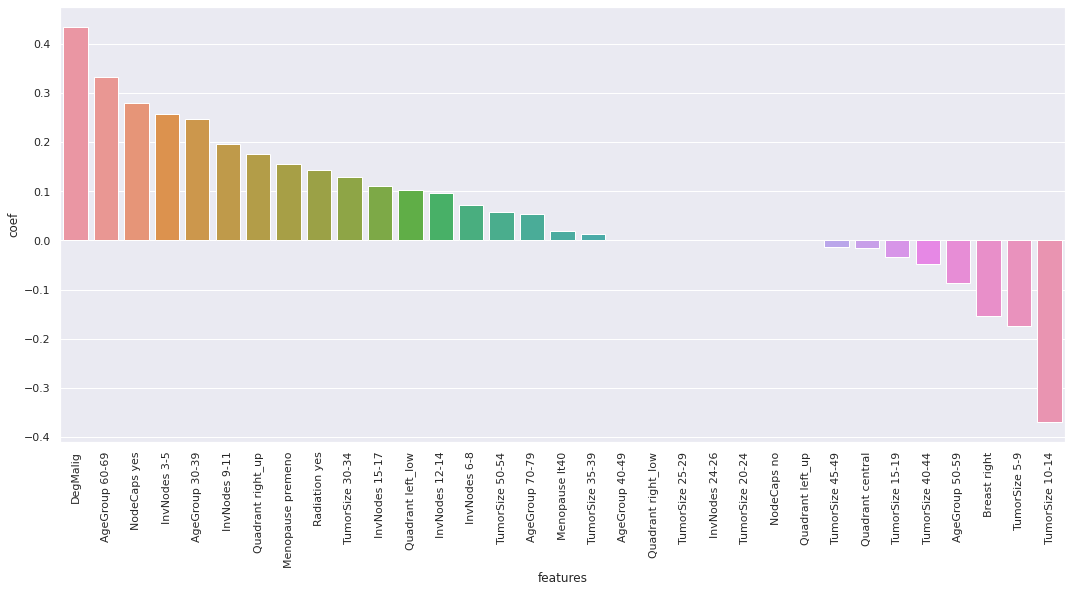

In [114]:
plt.figure(figsize=(18,8))
sns.barplot(x='features', y='coef', data=coefs_df)
plt.xticks(rotation=90)

In [115]:
def coef_plot(category):

  coefs_1 = coefs_df.sort_values(by='coef', ascending=False).head(10)

  coefs_2 = coefs_df.sort_values(by='coef', ascending=False).tail(10)

  coefs = pd.concat([coefs_1, coefs_2], axis = 0)

  plt.figure(figsize=(10, 10))
  plt.title(f'Feature Coefficient for {category.title()} Predictors', fontsize = 10)
  sns.set_style('darkgrid')
  sns.barplot(data = coefs, 
              x = 'coef', 
              y = 'features', 
              orient = 'h', 
              palette = 'mako_r')
  plt.xlabel('coefficient', fontsize = 10)
  plt.ylabel('keys', fontsize = 10)
  plt.tick_params(labelsize = 10)

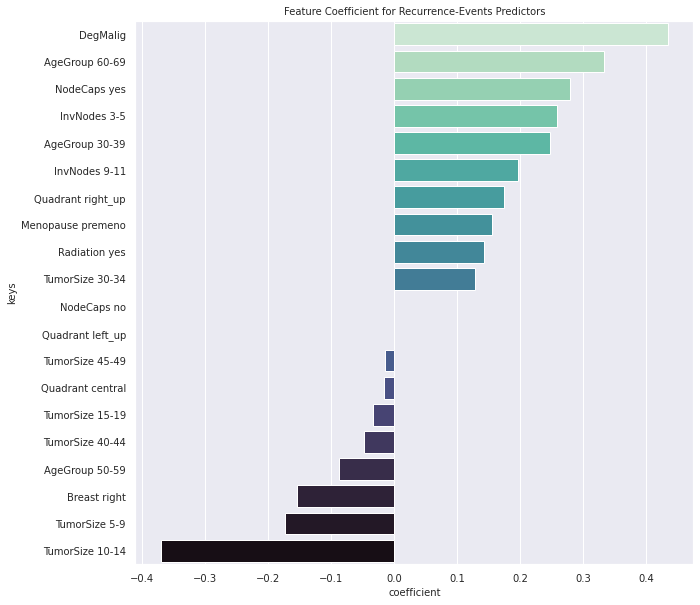

In [116]:
coef_plot('recurrence-events')

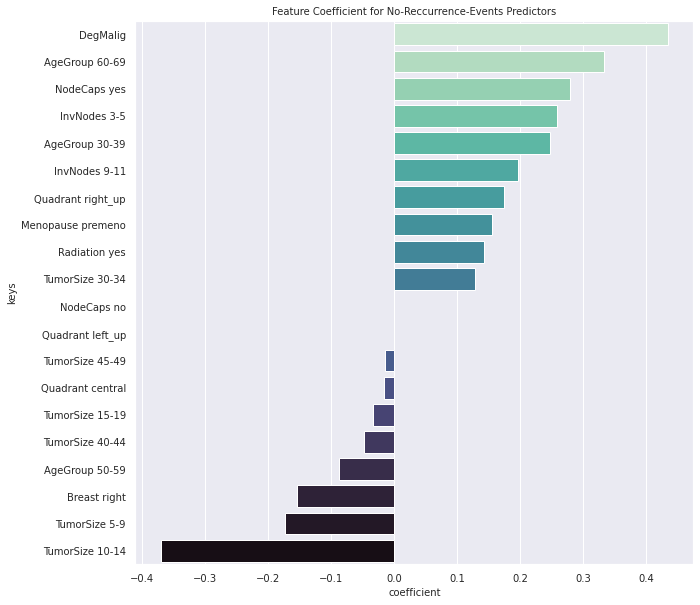

In [117]:
coef_plot('no-reccurrence-events')

In [ ]:
classes = gs_lr.best_estimator_.steps[0][1].classes_

odds = np.exp(gs_lr.best_estimator_.steps[0][1].coef_)

coefs_df = pd.DataFrame(odds[0], X.columns, columns=['coef']).sort_values(by='coef', ascending=False)

coefs_df

# Now, this makes sense
# It can be explained as follows
# "For every one-unit increase in X variable, the odds that the observations is in y class are 'coefficient' times as large as the odds that 
#...  the observation is not in y class when all other variables are held constant"

# So in this case, the more the patient belongs to AgeGroup 60-69, the odds of breast cancer recurrence are over 1.39x larger than the odds that breast cancer will not reoccur
# On the hand, if the patient has a TumorSize 10-14, the odds of cancer recurrence are only 0.69.
# For odds less than 1 or negative coeffs, we can take the 1/odds to make even better sense of them. 
# So as the TumorSize increases by 1, the odds that the cancer does not reoccur are 1/0.69 as likely as the odds that it is in the target class.

######## Need to recheck